# About this kernel
* Use gradient accumulation with TPU

    * With EfficientNetB7, the effective batch size can be up to 2048 images.
    * With smaller model like Xception, the effective batch size can be even higher.
    * For most NLP tasks, the effective batch size can even be 16384 or higher (because each input example is just a sequence of token ids, usually having length <= 512)
    * If you ever use my kernel [Tutorial -- Oversample](https://www.kaggle.com/yihdarshieh/tutorial-oversample), it should benefit from larger batch size, because larger batches are more likely to contain training examples of every labels.
    * It's kind tricky to implement gradient accumulation. For those who want to know the details, check the documentation for the method `train_step_1_update()`.
    * To understand the configuration variables related to batch, see the comments inside the method `set_batch_configuration()`.


* It uses the optimization from Martin Görner's kernel [Custom Training Loop with 100+ flowers on TPU](https://www.kaggle.com/mgornergoogle/custom-training-loop-with-100-flowers-on-tpu).

* We also try a (linear) scaled learning rate at the end (larger batch size --> larger learning rate). However, you have to find the best learning rate by yourself. Since the larger batch size implies that the parameter updates in 1 epoch are fewer. Even with a larger larning rate, it might be necessary to increase epochs a bit. 

* No submission file is generated, and no confusion matrix is plotted. The purpose of this kernel is to show how to do gradient accumulation with TPU. If you find this helpful, you should make you own kernel by modifying this kernel or copy some code from it.

# Idea


Each time, TPU receives a set of traning examples of size 

        BATCH_SIZE_PER_REPLICA * BATCHES_PER_UPDATE * strategy.num_replicas_in_sync


These examples are distributed to all replicas, so each replica receives training examples of size

        BATCH_SIZE_PER_REPLICA * BATCHES_PER_UPDATE
    
Each replica processes this set of example in `BATCHES_PER_UPDATE` times, i.e. it computes the loss and gradients on subsets of size `BATCH_SIZE_PER_REPLICA` and accumulate the gradients.

The final accumulated gradients on each replica are synchronized accros replicas by summing them (this is done by TPU automatically) and the optimizer use it to update the model's parameters.

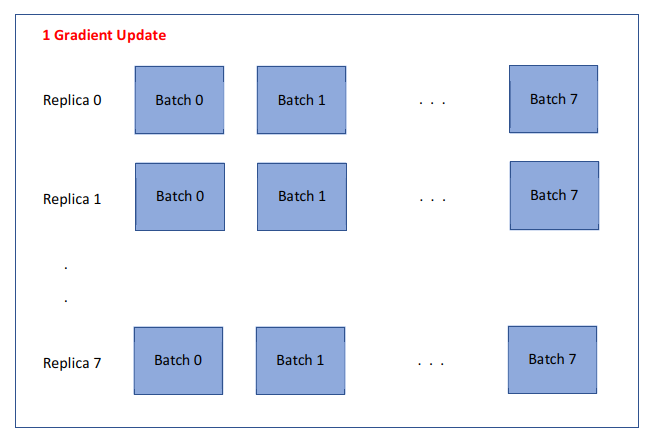



In [ ]:
import math, re, os, time
import datetime
import tensorflow as tf
import numpy as np
from collections import namedtuple
from matplotlib import pyplot as plt
from kaggle_datasets import KaggleDatasets
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
print("Tensorflow version " + tf.__version__)
AUTO = tf.data.experimental.AUTOTUNE

!pip install -q efficientnet
import efficientnet.tfkeras as efn

import gc
gc.enable()

# TPU or GPU detection

In [ ]:
# Detect hardware, return appropriate distribution strategy
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() # default distribution strategy in Tensorflow. Works on CPU and single GPU.

print("REPLICAS: ", strategy.num_replicas_in_sync)

# Competition data access
TPUs read data directly from Google Cloud Storage (GCS). This Kaggle utility will copy the dataset to a GCS bucket co-located with the TPU. If you have multiple datasets attached to the notebook, you can pass the name of a specific dataset to the get_gcs_path function. The name of the dataset is the name of the directory it is mounted in. Use `!ls /kaggle/input/` to list attached datasets.

In [ ]:
GCS_DS_PATH = KaggleDatasets().get_gcs_path() # you can list the bucket with "!gsutil ls $GCS_DS_PATH"

# Configuration

In [ ]:
IMAGE_SIZE = [512, 512] # At this size, a GPU will run out of memory. Use the TPU.
                        # For GPU training, please select 224 x 224 px image size.

GCS_PATH_SELECT = { # available image sizes
    192: GCS_DS_PATH + '/tfrecords-jpeg-192x192',
    224: GCS_DS_PATH + '/tfrecords-jpeg-224x224',
    331: GCS_DS_PATH + '/tfrecords-jpeg-331x331',
    512: GCS_DS_PATH + '/tfrecords-jpeg-512x512'
}
GCS_PATH = GCS_PATH_SELECT[IMAGE_SIZE[0]]

TRAINING_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/train/*.tfrec')
VALIDATION_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/val/*.tfrec')
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/test/*.tfrec') # predictions on this dataset should be submitted for the competition

CLASSES = ['pink primrose',    'hard-leaved pocket orchid', 'canterbury bells', 'sweet pea',     'wild geranium',     'tiger lily',           'moon orchid',              'bird of paradise', 'monkshood',        'globe thistle',         # 00 - 09
           'snapdragon',       "colt's foot",               'king protea',      'spear thistle', 'yellow iris',       'globe-flower',         'purple coneflower',        'peruvian lily',    'balloon flower',   'giant white arum lily', # 10 - 19
           'fire lily',        'pincushion flower',         'fritillary',       'red ginger',    'grape hyacinth',    'corn poppy',           'prince of wales feathers', 'stemless gentian', 'artichoke',        'sweet william',         # 20 - 29
           'carnation',        'garden phlox',              'love in the mist', 'cosmos',        'alpine sea holly',  'ruby-lipped cattleya', 'cape flower',              'great masterwort', 'siam tulip',       'lenten rose',           # 30 - 39
           'barberton daisy',  'daffodil',                  'sword lily',       'poinsettia',    'bolero deep blue',  'wallflower',           'marigold',                 'buttercup',        'daisy',            'common dandelion',      # 40 - 49
           'petunia',          'wild pansy',                'primula',          'sunflower',     'lilac hibiscus',    'bishop of llandaff',   'gaura',                    'geranium',         'orange dahlia',    'pink-yellow dahlia',    # 50 - 59
           'cautleya spicata', 'japanese anemone',          'black-eyed susan', 'silverbush',    'californian poppy', 'osteospermum',         'spring crocus',            'iris',             'windflower',       'tree poppy',            # 60 - 69
           'gazania',          'azalea',                    'water lily',       'rose',          'thorn apple',       'morning glory',        'passion flower',           'lotus',            'toad lily',        'anthurium',             # 70 - 79
           'frangipani',       'clematis',                  'hibiscus',         'columbine',     'desert-rose',       'tree mallow',          'magnolia',                 'cyclamen ',        'watercress',       'canna lily',            # 80 - 89
           'hippeastrum ',     'bee balm',                  'pink quill',       'foxglove',      'bougainvillea',     'camellia',             'mallow',                   'mexican petunia',  'bromelia',         'blanket flower',        # 90 - 99
           'trumpet creeper',  'blackberry lily',           'common tulip',     'wild rose']                                                                                                                                               # 100 - 102

# Learning rate schedule for TPU, GPU and CPU.
# Using an LR ramp up because fine-tuning a pre-trained model.
# Starting with a high LR would break the pre-trained weights.

LR_START = 0.00001
LR_MAX = 0.00005 * strategy.num_replicas_in_sync
LR_MIN = 0.00001
LR_RAMPUP_EPOCHS = 5
LR_SUSTAIN_EPOCHS = 0
LR_EXP_DECAY = .8
        
@tf.function
def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        lr = (LR_MAX - LR_MIN) * LR_EXP_DECAY**(epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS) + LR_MIN
    return lr

rng = [i for i in range(20)]
y = [lrfn(x) for x in rng]
plt.plot(rng, y)
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}".format(y[0], max(y), y[-1]))

## Visualization utilities
data -> pixels, nothing of much interest for the machine learning practitioner in this section.

In [ ]:
# numpy and matplotlib defaults
np.set_printoptions(threshold=15, linewidth=80)

def batch_to_numpy_images_and_labels(data):
    images, labels = data
    numpy_images = images.numpy()
    numpy_labels = labels.numpy()
    if numpy_labels.dtype == object: # binary string in this case, these are image ID strings
        numpy_labels = [None for _ in enumerate(numpy_images)]
    # If no labels, only image IDs, return None for labels (this is the case for test data)
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    if correct_label is None:
        return CLASSES[label], True
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], 'OK' if correct else 'NO', u"\u2192" if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False, titlesize=16):
    plt.subplot(*subplot)
    plt.axis('off')
    plt.imshow(image)
    if len(title) > 0:
        plt.title(title, fontsize=int(titlesize) if not red else int(titlesize/1.2), color='red' if red else 'black', fontdict={'verticalalignment':'center'}, pad=int(titlesize/1.5))
    return (subplot[0], subplot[1], subplot[2]+1)
    
def display_batch_of_images(databatch, predictions=None):
    """This will work with:
    display_batch_of_images(images)
    display_batch_of_images(images, predictions)
    display_batch_of_images((images, labels))
    display_batch_of_images((images, labels), predictions)
    """
    # data
    images, labels = batch_to_numpy_images_and_labels(databatch)
    if labels is None:
        labels = [None for _ in enumerate(images)]
        
    # auto-squaring: this will drop data that does not fit into square or square-ish rectangle
    rows = int(math.sqrt(len(images)))
    cols = len(images)//rows
        
    # size and spacing
    FIGSIZE = 13.0
    SPACING = 0.1
    subplot=(rows,cols,1)
    if rows < cols:
        plt.figure(figsize=(FIGSIZE,FIGSIZE/cols*rows))
    else:
        plt.figure(figsize=(FIGSIZE/rows*cols,FIGSIZE))
    
    # display
    for i, (image, label) in enumerate(zip(images[:rows*cols], labels[:rows*cols])):
        title = '' if label is None else CLASSES[label]
        correct = True
        if predictions is not None:
            title, correct = title_from_label_and_target(predictions[i], label)
        dynamic_titlesize = FIGSIZE*SPACING/max(rows,cols)*40+3 # magic formula tested to work from 1x1 to 10x10 images
        subplot = display_one_flower(image, title, subplot, not correct, titlesize=dynamic_titlesize)
    
    #layout
    plt.tight_layout()
    if label is None and predictions is None:
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        plt.subplots_adjust(wspace=SPACING, hspace=SPACING)
    plt.show()

def display_confusion_matrix(cmat, score, precision, recall):
    plt.figure(figsize=(15,15))
    ax = plt.gca()
    ax.matshow(cmat, cmap='Reds')
    ax.set_xticks(range(len(CLASSES)))
    ax.set_xticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_xticklabels(), rotation=45, ha="left", rotation_mode="anchor")
    ax.set_yticks(range(len(CLASSES)))
    ax.set_yticklabels(CLASSES, fontdict={'fontsize': 7})
    plt.setp(ax.get_yticklabels(), rotation=45, ha="right", rotation_mode="anchor")
    titlestring = ""
    if score is not None:
        titlestring += 'f1 = {:.3f} '.format(score)
    if precision is not None:
        titlestring += '\nprecision = {:.3f} '.format(precision)
    if recall is not None:
        titlestring += '\nrecall = {:.3f} '.format(recall)
    if len(titlestring) > 0:
        ax.text(101, 1, titlestring, fontdict={'fontsize': 18, 'horizontalalignment':'right', 'verticalalignment':'top', 'color':'#804040'})
    plt.show()
    
def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(10,10), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title('model '+ title)
    ax.set_ylabel(title)
    #ax.set_ylim(0.28,1.05)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

# Datasets

In [ ]:
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels=3)
    image = tf.cast(image, tf.float32) / 255.0  # convert image to floats in [0, 1] range
    image = tf.reshape(image, [*IMAGE_SIZE, 3]) # explicit size needed for TPU
    return image

def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "class": tf.io.FixedLenFeature([], tf.int64),  # shape [] means single element
    }
    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    label = tf.cast(example['class'], tf.int32)
    return image, label # returns a dataset of (image, label) pairs

def read_unlabeled_tfrecord(example):
    UNLABELED_TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string), # tf.string means bytestring
        "id": tf.io.FixedLenFeature([], tf.string),  # shape [] means single element
        # class is missing, this competitions's challenge is to predict flower classes for the test dataset
    }
    example = tf.io.parse_single_example(example, UNLABELED_TFREC_FORMAT)
    image = decode_image(example['image'])
    idnum = example['id']
    return image, idnum # returns a dataset of image(s)

def load_dataset(filenames, labeled=True, ordered=False):
    # Read from TFRecords. For optimal performance, reading from multiple files at once and
    # disregarding data order. Order does not matter since we will be shuffling the data anyway.

    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(read_labeled_tfrecord if labeled else read_unlabeled_tfrecord, num_parallel_calls=AUTO)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

def data_augment(image, label):
    # data augmentation. Thanks to the dataset.prefetch(AUTO) statement in the next function (below),
    # this happens essentially for free on TPU. Data pipeline code is executed on the "CPU" part
    # of the TPU while the TPU itself is computing gradients.
    image = tf.image.random_flip_left_right(image)
    #image = tf.image.random_saturation(image, 0, 2)
    return image, label   

def get_training_dataset(batch_size):
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(data_augment, num_parallel_calls=AUTO)
    dataset = dataset.repeat() # the training dataset must repeat for several epochs
    dataset = dataset.shuffle(12753)
    dataset = dataset.batch(batch_size, drop_remainder=True) # slighly faster with fixed tensor sizes
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_validation_dataset(batch_size, ordered=False, repeated=False):
    dataset = load_dataset(VALIDATION_FILENAMES, labeled=True, ordered=ordered)
    if repeated:
        dataset = dataset.repeat()
        dataset = dataset.shuffle(3712)
    dataset = dataset.batch(batch_size, drop_remainder=repeated) # slighly faster with fixed tensor sizes
    # dataset = dataset.cache()  # seems this is problematic in the setting of this kernel
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def get_test_dataset(batch_size, ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    return dataset

def count_data_items(filenames):
    # the number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

def int_div_round_up(a, b):
    return (a + b - 1) // b

NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALIDATION_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)

#VALIDATION_STEPS = int_div_round_up(NUM_VALIDATION_IMAGES, BATCH_SIZE)
print('Dataset: {} training images, {} validation images, {} unlabeled test images'.format(NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES))

# Dataset visualizations

In [ ]:
# Peek at training data
training_dataset = get_training_dataset(batch_size=20)
training_dataset = training_dataset.unbatch().batch(20)
train_batch = iter(training_dataset)

In [ ]:
# run this cell again for next set of images
display_batch_of_images(next(train_batch))

In [ ]:
# peer at test data
test_dataset = get_test_dataset(batch_size=20)
test_dataset = test_dataset.unbatch().batch(20)
test_batch = iter(test_dataset)

In [ ]:
# run this cell again for next set of images
display_batch_of_images(next(test_batch))

# Batch Configuration

In [ ]:
def set_batch_configuration(batch_size_per_replica, batches_per_update):

    # The number of examples for which the training procedure running on a single replica will compute the gradients in order to accumulate them.
    BATCH_SIZE_PER_REPLICA = batch_size_per_replica

    # The total number of examples for which the training procedure will compute the gradients in order to accumulate them.
    # This is also used for validation step.
    BATCH_SIZE = BATCH_SIZE_PER_REPLICA * strategy.num_replicas_in_sync

    # Accumulate `BATCHES_PER_UPDATE` of gradients before updating the model's parameters.
    BATCHES_PER_UPDATE = batches_per_update

    # The number of examples for which the training procedure will update the model's parameters once.
    # This is the `effective` batch size, which will be used in tf.data.Dataset. 
    UPDATE_SIZE = BATCH_SIZE * BATCHES_PER_UPDATE

    # The number of parameter updates in 1 epoch
    UPDATES_PER_EPOCH = NUM_TRAINING_IMAGES // UPDATE_SIZE

    # The number of batches for a validation step.
    VALID_BATCHES_PER_EPOCH = NUM_VALIDATION_IMAGES // BATCH_SIZE

    return BATCH_SIZE_PER_REPLICA, BATCH_SIZE, BATCHES_PER_UPDATE, UPDATE_SIZE, UPDATES_PER_EPOCH, VALID_BATCHES_PER_EPOCH

# Optimized custom training loop
Optimized by calling the TPU less often and performing more steps per call
## Model

In [ ]:
def set_model(learning_rate_scaling=1):

    with strategy.scope():

        pretrained_model = tf.keras.applications.Xception(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
        # pretrained_model = efn.EfficientNetB7(weights='imagenet', include_top=False ,input_shape=[*IMAGE_SIZE, 3])
        
        pretrained_model.trainable = True # False = transfer learning, True = fine-tuning

        model = tf.keras.Sequential([
            pretrained_model,
            tf.keras.layers.GlobalAveragePooling2D(),
            tf.keras.layers.Dense(len(CLASSES), activation='softmax')
        ])
        model.summary()

        # Instiate optimizer with learning rate schedule
        class LRSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
            def __call__(self, step):
                return learning_rate_scaling * lrfn(epoch=step // UPDATES_PER_EPOCH)

        optimizer = tf.keras.optimizers.Adam(learning_rate=LRSchedule())

        # Instantiate metrics
        train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
        valid_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()
        train_loss = tf.keras.metrics.Sum()
        valid_loss = tf.keras.metrics.Sum()

        # Loss
        loss_fn = tf.keras.losses.sparse_categorical_crossentropy
        
        return model, loss_fn, optimizer, train_accuracy, train_loss, valid_accuracy, valid_loss

# Training routines

In [ ]:
def set_routines():

    with strategy.scope():

        def train_step_1_forward_backward(images, labels):
            """
            The procedure to be run on each replica that computes gradients by feedforward and backpropagation.

            The `images` and `labels` must have batch dimension equal to `BATCH_SIZE_PER_REPLICA`.
            """

            with tf.GradientTape() as tape:

                probabilities = model(images, training=True)
                per_example_loss = loss_fn(labels, probabilities)
                loss = tf.math.reduce_sum(per_example_loss) / UPDATE_SIZE

            grads = tape.gradient(loss, model.trainable_variables)

            # update metrics
            train_accuracy.update_state(labels, probabilities)
            train_loss.update_state(loss)    

            return grads


        def train_step_1_update(images, labels):
            """
            The procedure to be run on each replica that computes gradients
            in an accumulated way and updates the model's parameter
            (once the accumulated gradients on each replica are synced across the replicas by summing them).

            The `images` and `labels` must have batch dimension equal to `BATCHES_PER_UPDATE * BATCH_SIZE_PER_REPLICA`.
            They are splitted into `BATCHES_PER_UPDATE` parts, and each part (which has batch dimension `BATCH_SIZE_PER_REPLICA`)
            is sent to `train_step_1_forward_backward()` to compute the loss and gradients, then the gradients are added to `accumulated_grads`.

            *** Implementation detail:

                In order to split `images` and `labels` into smaller portions, the easiest way is to do something like `images[start_idx:end_idx]`
                with `start_idx = BATCHES_PER_UPDATE * batch_idx` and `end_idx = start_idx + BATCHES_PER_UPDATE`.

                However, this gives the following error:

                    Compilation failure: XLA can't deduce compile time constant output shape for strided slice: [?,512,512,3],
                    output shape must be a compile-time constant.

                Similar error is thrown for `tf.gather(images, tf.range(start_idx, end_idx))`.

                If we use the trick like `images[:BATCH_SIZE_PER_REPLICA]` at the beginning inside the `for` loop
                and modify `images` by `images = images[BATCH_SIZE_PER_REPLICA:]` at the end inside the `for` loop,
                we get another error:

                    "images" has shape (256, 512, 512, 3) before the loop, but shape (240, 512, 512, 3) after one iteration.
                    TensorFlow control flow requires it stays the same or be more specific.

                The solution given here is to do the following trick:

                    for batch_idx in tf.range(BATCHES_PER_UPDATE):

                        ...

                        small_images = images[:BATCH_SIZE_PER_REPLICA]

                        ...

                        tf.concat([images[BATCH_SIZE_PER_REPLICA:], small_images], axis=0)

                The idea is to take the first `BATCHES_PER_UPDATE` examples from `images` and pass them to `train_step_1_forward_backward`, and then
                move this portion to the end of `images`, so `images` always has the same shape, although the content is modified.

            Args:

                images: tf.Tensor with shape [BATCHES_PER_UPDATE * BATCH_SIZE_PER_REPLICA , height, width, depth]

                labels: tf.Tensor with shape [BATCHES_PER_UPDATE * BATCH_SIZE_PER_REPLICA]
            """

            accumulated_grads = [tf.zeros_like(var, dtype=tf.float32) for var in model.trainable_variables]

            for batch_idx in tf.range(BATCHES_PER_UPDATE):

                # This is not working. (Error: output shape must be a compile-time constant.)
                # start_idx = BATCHES_PER_UPDATE * batch_idx
                # end_idx = start_idx + BATCHES_PER_UPDATE
                # small_images = images[start_idx:end_idx]
                # small_labels = labels[start_idx:end_idx]

                # Take the 1st `BATCH_SIZE_PER_REPLICA` examples.
                small_images = images[:BATCH_SIZE_PER_REPLICA]
                small_labels = labels[:BATCH_SIZE_PER_REPLICA]      

                grads = train_step_1_forward_backward(small_images, small_labels)

                accumulated_grads = [x + y for x, y in zip(accumulated_grads, grads)]

                # Move the leading part to the end, so the shape is not changed.
                images = tf.concat([images[BATCH_SIZE_PER_REPLICA:], small_images], axis=0)
                labels = tf.concat([labels[BATCH_SIZE_PER_REPLICA:], small_labels], axis=0)

            # Update the model's parameters.
            optimizer.apply_gradients(zip(accumulated_grads, model.trainable_variables))


        @tf.function
        def train_step_1_epoch(data_iter):

            for _ in tf.range(UPDATES_PER_EPOCH):  
                strategy.experimental_run_v2(train_step_1_update, next(data_iter))
                
                
        @tf.function
        def valid_step(data_iter):

            def valid_step_fn(images, labels):

                probabilities = model(images, training=False)
                per_example_loss = loss_fn(labels, probabilities)
                loss = tf.math.reduce_sum(per_example_loss) / BATCH_SIZE

                # update metrics
                valid_accuracy.update_state(labels, probabilities)
                valid_loss.update_state(loss)

            for _ in tf.range(VALID_BATCHES_PER_EPOCH):
                strategy.experimental_run_v2(valid_step_fn, next(data_iter))                
                
    return train_step_1_epoch, valid_step

# Training without gradient accumulation

### BATCH_SIZE_PER_REPLICA = 16
### BATCHES_PER_UPDATE = 1

* Effective batch size = 16 \* 8 \* 8 = 128
* The original setting

In [ ]:
BATCH_SIZE_PER_REPLICA, BATCH_SIZE, BATCHES_PER_UPDATE, UPDATE_SIZE, UPDATES_PER_EPOCH, VALID_BATCHES_PER_EPOCH = set_batch_configuration(batch_size_per_replica=16, batches_per_update=1)
model, loss_fn, optimizer, train_accuracy, train_loss, valid_accuracy, valid_loss = set_model(learning_rate_scaling=8)
train_step_1_epoch, valid_step = set_routines()

print("BATCH_SIZE_PER_REPLICA: {}".format(BATCH_SIZE_PER_REPLICA))
print("BATCH_SIZE: {}".format(BATCH_SIZE))
print("BATCHES_PER_UPDATE: {}".format(BATCHES_PER_UPDATE))
print("UPDATE_SIZE: {}".format(UPDATE_SIZE))
print("UPDATES_PER_EPOCH: {}".format(UPDATES_PER_EPOCH))
print("VALID_BATCHES_PER_EPOCH: {}".format(VALID_BATCHES_PER_EPOCH))

In [ ]:
train_ds = get_training_dataset(batch_size=UPDATE_SIZE)
train_dist_ds = strategy.experimental_distribute_dataset(train_ds)
train_data_iter = iter(train_dist_ds)

valid_ds = get_validation_dataset(batch_size=BATCH_SIZE, repeated=True)
valid_dist_ds = strategy.experimental_distribute_dataset(valid_ds)
valid_data_iter = iter(valid_dist_ds)

EPOCHS = 20
for epoch_idx in range(EPOCHS):
    
    s = datetime.datetime.now()
    
    train_step_1_epoch(train_data_iter)
    
    loss = train_loss.result() / UPDATES_PER_EPOCH
    acc = train_accuracy.result()
    
    print("epoch: {}".format(epoch_idx + 1))

    print("train loss: {}".format(loss))
    print("train accuracy: {}".format(acc))

    train_loss.reset_states()
    train_accuracy.reset_states()
        
    e = datetime.datetime.now()
    print("elapsed: {}".format((e-s).total_seconds()))
    
    valid_step(valid_data_iter)
    
    val_loss = valid_loss.result() / VALID_BATCHES_PER_EPOCH
    val_acc = valid_accuracy.result()    
    
    print("valid loss: {}".format(val_loss))
    print("valid accuracy: {}".format(val_acc))    
    
    valid_loss.reset_states()
    valid_accuracy.reset_states()    
    
    print("-" * 80)
    
del optimizer
del model
del train_step_1_epoch
gc.collect()
tf.keras.backend.clear_session()

# Training with gradient accumulation

### BATCH_SIZE_PER_REPLICA = 16
### BATCHES_PER_UPDATE = 8

* Effective batch size = 16 \* 8 \* 8 = 1024
* BATCH_SIZE_PER_REPLICA = 16 with BATCHES_PER_UPDATE = 16 --> Not enough TPU memory

In [ ]:
BATCH_SIZE_PER_REPLICA, BATCH_SIZE, BATCHES_PER_UPDATE, UPDATE_SIZE, UPDATES_PER_EPOCH, VALID_BATCHES_PER_EPOCH = set_batch_configuration(batch_size_per_replica=16, batches_per_update=8)
model, loss_fn, optimizer, train_accuracy, train_loss, valid_accuracy, valid_loss = set_model(learning_rate_scaling=1)
train_step_1_epoch, valid_step = set_routines()

print("BATCH_SIZE_PER_REPLICA: {}".format(BATCH_SIZE_PER_REPLICA))
print("BATCH_SIZE: {}".format(BATCH_SIZE))
print("BATCHES_PER_UPDATE: {}".format(BATCHES_PER_UPDATE))
print("UPDATE_SIZE: {}".format(UPDATE_SIZE))
print("UPDATES_PER_EPOCH: {}".format(UPDATES_PER_EPOCH))
print("VALID_BATCHES_PER_EPOCH: {}".format(VALID_BATCHES_PER_EPOCH))

In [ ]:
train_ds = get_training_dataset(batch_size=UPDATE_SIZE)
train_dist_ds = strategy.experimental_distribute_dataset(train_ds)
train_data_iter = iter(train_dist_ds)

valid_ds = get_validation_dataset(batch_size=BATCH_SIZE, repeated=True)
valid_dist_ds = strategy.experimental_distribute_dataset(valid_ds)
valid_data_iter = iter(valid_dist_ds)

EPOCHS = 20
for epoch_idx in range(EPOCHS):
    
    s = datetime.datetime.now()
    
    train_step_1_epoch(train_data_iter)
    
    loss = train_loss.result() / UPDATES_PER_EPOCH
    acc = train_accuracy.result()
    
    print("epoch: {}".format(epoch_idx + 1))

    print("train loss: {}".format(loss))
    print("train accuracy: {}".format(acc))

    train_loss.reset_states()
    train_accuracy.reset_states()
        
    e = datetime.datetime.now()
    print("elapsed: {}".format((e-s).total_seconds()))
    
    valid_step(valid_data_iter)
    
    val_loss = valid_loss.result() / VALID_BATCHES_PER_EPOCH
    val_acc = valid_accuracy.result()    
    
    print("valid loss: {}".format(val_loss))
    print("valid accuracy: {}".format(val_acc))    
    
    valid_loss.reset_states()
    valid_accuracy.reset_states()    
    
    print("-" * 80)
    
del optimizer
del model
del train_step_1_epoch
gc.collect()
tf.keras.backend.clear_session()

# Training with gradient accumulation with even higer effective batch size

### BATCH_SIZE_PER_REPLICA = 8
### BATCHES_PER_UPDATE = 32

* Effective batch size = 8 \* 32 \* 8 = 2048
* BATCH_SIZE_PER_REPLICA = 8 with BATCHES_PER_UPDATE = 64 --> Not enough TPU memory

In [ ]:
BATCH_SIZE_PER_REPLICA, BATCH_SIZE, BATCHES_PER_UPDATE, UPDATE_SIZE, UPDATES_PER_EPOCH, VALID_BATCHES_PER_EPOCH = set_batch_configuration(batch_size_per_replica=8, batches_per_update=32)
model, loss_fn, optimizer, train_accuracy, train_loss, valid_accuracy, valid_loss = set_model(learning_rate_scaling=1)
train_step_1_epoch, valid_step = set_routines()

print("BATCH_SIZE_PER_REPLICA: {}".format(BATCH_SIZE_PER_REPLICA))
print("BATCH_SIZE: {}".format(BATCH_SIZE))
print("BATCHES_PER_UPDATE: {}".format(BATCHES_PER_UPDATE))
print("UPDATE_SIZE: {}".format(UPDATE_SIZE))
print("UPDATES_PER_EPOCH: {}".format(UPDATES_PER_EPOCH))
print("VALID_BATCHES_PER_EPOCH: {}".format(VALID_BATCHES_PER_EPOCH))

In [ ]:
train_ds = get_training_dataset(batch_size=UPDATE_SIZE)
train_dist_ds = strategy.experimental_distribute_dataset(train_ds)
train_data_iter = iter(train_dist_ds)

valid_ds = get_validation_dataset(batch_size=BATCH_SIZE, repeated=True)
valid_dist_ds = strategy.experimental_distribute_dataset(valid_ds)
valid_data_iter = iter(valid_dist_ds)

EPOCHS = 20
for epoch_idx in range(EPOCHS):
    
    s = datetime.datetime.now()
    
    train_step_1_epoch(train_data_iter)
    
    loss = train_loss.result() / UPDATES_PER_EPOCH
    acc = train_accuracy.result()
    
    print("epoch: {}".format(epoch_idx + 1))

    print("train loss: {}".format(loss))
    print("train accuracy: {}".format(acc))

    train_loss.reset_states()
    train_accuracy.reset_states()
        
    e = datetime.datetime.now()
    print("elapsed: {}".format((e-s).total_seconds()))
    
    valid_step(valid_data_iter)
    
    val_loss = valid_loss.result() / VALID_BATCHES_PER_EPOCH
    val_acc = valid_accuracy.result()    
    
    print("valid loss: {}".format(val_loss))
    print("valid accuracy: {}".format(val_acc))    
    
    valid_loss.reset_states()
    valid_accuracy.reset_states()    
    
    print("-" * 80)
    
del optimizer
del model
del train_step_1_epoch
gc.collect()
tf.keras.backend.clear_session()

# Training with gradient accumulation with even higer effective batch size + larger learning rate

### BATCH_SIZE_PER_REPLICA = 8
### BATCHES_PER_UPDATE = 32

* Effective batch size = 8 \* 32 \* 8 = 2048
* scale the learning rate by 16 times of the original learning rate (because the effective batch size is 16 times larger)

In [ ]:
BATCH_SIZE_PER_REPLICA, BATCH_SIZE, BATCHES_PER_UPDATE, UPDATE_SIZE, UPDATES_PER_EPOCH, VALID_BATCHES_PER_EPOCH = set_batch_configuration(batch_size_per_replica=8, batches_per_update=32)
model, loss_fn, optimizer, train_accuracy, train_loss, valid_accuracy, valid_loss = set_model(learning_rate_scaling=16)
train_step_1_epoch, valid_step = set_routines()

print("BATCH_SIZE_PER_REPLICA: {}".format(BATCH_SIZE_PER_REPLICA))
print("BATCH_SIZE: {}".format(BATCH_SIZE))
print("BATCHES_PER_UPDATE: {}".format(BATCHES_PER_UPDATE))
print("UPDATE_SIZE: {}".format(UPDATE_SIZE))
print("UPDATES_PER_EPOCH: {}".format(UPDATES_PER_EPOCH))
print("VALID_BATCHES_PER_EPOCH: {}".format(VALID_BATCHES_PER_EPOCH))

In [ ]:
train_ds = get_training_dataset(batch_size=UPDATE_SIZE)
train_dist_ds = strategy.experimental_distribute_dataset(train_ds)
train_data_iter = iter(train_dist_ds)

valid_ds = get_validation_dataset(batch_size=BATCH_SIZE, repeated=True)
valid_dist_ds = strategy.experimental_distribute_dataset(valid_ds)
valid_data_iter = iter(valid_dist_ds)

EPOCHS = 20
for epoch_idx in range(EPOCHS):
    
    s = datetime.datetime.now()
    
    train_step_1_epoch(train_data_iter)
    
    loss = train_loss.result() / UPDATES_PER_EPOCH
    acc = train_accuracy.result()
    
    print("epoch: {}".format(epoch_idx + 1))

    print("train loss: {}".format(loss))
    print("train accuracy: {}".format(acc))

    train_loss.reset_states()
    train_accuracy.reset_states()
        
    e = datetime.datetime.now()
    print("elapsed: {}".format((e-s).total_seconds()))
    
    valid_step(valid_data_iter)
    
    val_loss = valid_loss.result() / VALID_BATCHES_PER_EPOCH
    val_acc = valid_accuracy.result()    
    
    print("valid loss: {}".format(val_loss))
    print("valid accuracy: {}".format(val_acc))    
    
    valid_loss.reset_states()
    valid_accuracy.reset_states()    
    
    print("-" * 80)
    
del optimizer
del model
del train_step_1_epoch
gc.collect()
tf.keras.backend.clear_session()